<img title="GitHub Octocat" src='./img/Octocat.jpg' style='height: 60px; padding-right: 15px' alt="Octocat" align="left"> This notebook is part of a GitHub repository: https://github.com/pessini/moby-bikes 
<br>MIT Licensed
<br>Author: Leandro Pessini

# <p style="font-size:100%; text-align:left; color:#444444;">Models</p>

# <p style="font-size:100%; text-align:left; color:#444444;">Table of Contents:</p>
* [1. Datasets](#1)
  * [1.1 Rentals Data - Moby Bikes](#1.1)
  * [1.2 Weather Data - Met Éireann](#1.2)
* [2. Preprocessing & Feature Engineering](#2)
  * [2.1 Target variable distribution](#2.1)
  * [2.2 Missing values](#2.2)
  * [2.3 Exploratory Analysis](#2.3)
  * [2.4 Features Importance](#2.4)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Models & Evaluation
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
from xgboost import XGBRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
import catboost as cat
from catboost import CatBoostRegressor
from sklearn import metrics

# Hyperparameter optimization
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import time
import warnings
warnings.simplefilter('ignore', FutureWarning)

In [2]:
from platform import python_version
print('Python version:', python_version())

Python version: 3.9.6


In [3]:
%reload_ext watermark
%watermark -a "Leandro Pessini" --iversions

Author: Leandro Pessini

xgboost   : 1.4.0
matplotlib: 3.4.2
seaborn   : 0.11.1
sys       : 3.9.6 | packaged by conda-forge | (default, Jul 11 2021, 03:36:15) 
[Clang 11.1.0 ]
numpy     : 1.21.1
lightgbm  : 3.2.1
pandas    : 1.3.0
sklearn   : 1.0.2
catboost  : 0.26.1



## Splitting dataset in train and test

In [4]:
hourly_data = pd.read_csv('../data/processed/hourly_data.csv')
hourly_rentals = pd.read_csv('../data/processed/hourly_rentals.csv')
hourly_data.shape, hourly_rentals.shape

((8760, 18), (6966, 18))

In [5]:
df = hourly_rentals.copy()
df = df.astype({'holiday': 'category', 
                'dayofweek': 'category', 
                'working_day': 'category',
                'hour': 'category',
                'season': 'category',
                'peak': 'category',
                'timesofday': 'category'})
predictors = ['temp','wdsp','rhum','rain_type','holiday','season','dayofweek','working_day','peak','timesofday']


X = df[[c for c in df.columns if c in predictors]]
y = df.pop('count')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.shape, X_test.shape

((4876, 10), (2090, 10))

In [6]:
hourly_rentals.head()

,date,hour,rain,temp,rhum,wdsp,day,month,year,holiday,dayofweek_n,dayofweek,working_day,season,peak,timesofday,rain_type,count
0,2021-03-01,2,0.0,-1.2,98,4,1,3,2021,False,0,Monday,True,Winter,False,Night,no rain,1
1,2021-03-01,7,0.0,2.1,100,4,1,3,2021,False,0,Monday,True,Winter,True,Morning,no rain,3
2,2021-03-01,8,0.0,5.1,98,5,1,3,2021,False,0,Monday,True,Winter,True,Morning,no rain,1
3,2021-03-01,9,0.0,5.7,98,5,1,3,2021,False,0,Monday,True,Winter,True,Morning,no rain,4
4,2021-03-01,10,0.0,6.7,94,6,1,3,2021,False,0,Monday,True,Winter,True,Morning,no rain,4


## Split columns in categorical and numerical

In [7]:
num_vars = [n for n in df.select_dtypes(include=['number']).columns if n in predictors]
cat_vars = [c for c in df.select_dtypes(include=['category']).columns if c in predictors]
# nu
ord_var = ['rain_type']
num_vars, cat_vars, ord_var

(['temp', 'rhum', 'wdsp'],
 ['holiday', 'dayofweek', 'working_day', 'season', 'peak', 'timesofday'],
 ['rain_type'])

## Preprocessing Pipelines

In [8]:
# Define categorical pipeline
cat_pipe = Pipeline([
    #('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

# Define numerical pipeline
num_pipe = Pipeline([
    #('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
    # ('scaler', MinMaxScaler())
])

ord_pipe = Pipeline([
    ('ordinal_enconder', OrdinalEncoder(dtype=np.int64, categories=[['no rain', 
                                                                     'drizzle', 
                                                                     'light rain', 
                                                                     'moderate rain', 
                                                                     'heavy rain']]))
])

# Combine categorical and numerical pipelines
preprocessor = ColumnTransformer([
    ('cat', cat_pipe, cat_vars),
    ('ordinal_enconder', ord_pipe, ord_var),
    ('num', num_pipe, num_vars)
], remainder='passthrough')

In [9]:
def print_evalmetrics(actual, predicted):
    print('RMSE:', metrics.mean_squared_error(actual, predicted, squared=False))
    print('MAE:', metrics.mean_absolute_error(actual, predicted))

## Feature Importance

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=20, subsample_freq=0 will be ignored. Current value: bagging_freq=20
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=0.7 will be ignored. Current value: bagging_fraction=0.5


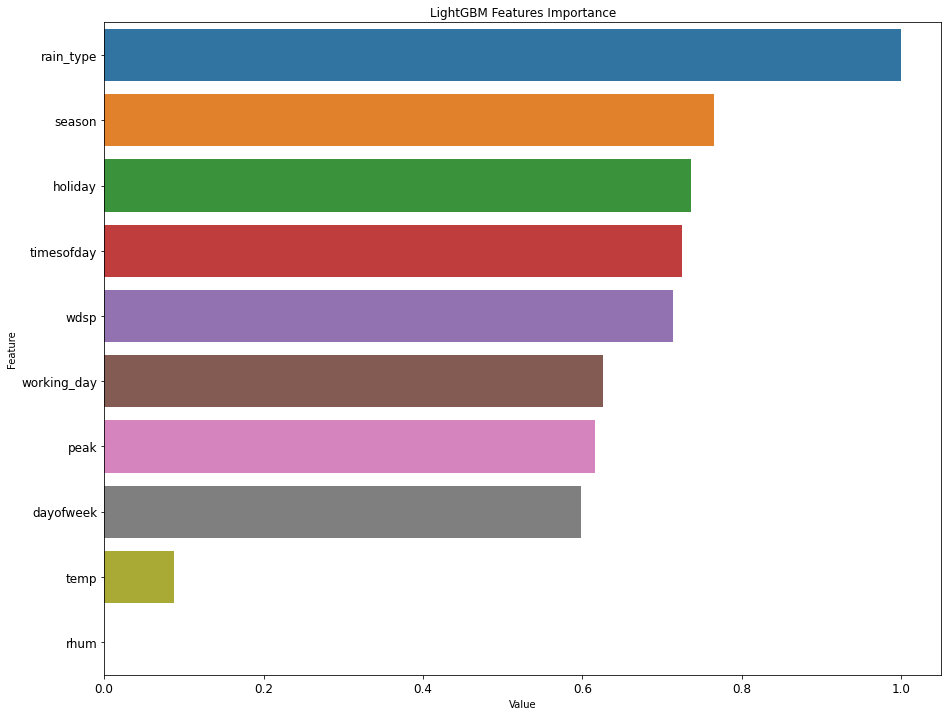

In [10]:
# LightGBM model
params_lightgbm = {'n_estimators': 5000,
                   'objective': 'l1',
                   'learning_rate': 0.01, 
                   'subsample': 0.7,
                   'verbosity': -1,
                   'feature_fraction': 0.5,
                   'bagging_fraction': 0.5,
                   'bagging_freq': 20,
                   'importance_type': 'gain'
                   }

# Fit a pipeline with transformers and an estimator to the training data
pipe_gbm = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LGBMRegressor(**params_lightgbm))
])
pipe_gbm.fit(X_train, y_train)

#Plotting features importance
feature_imp = pd.DataFrame(sorted(zip(pipe_gbm['model'].feature_importances_,X_train.columns)), 
                           columns=['Value','Feature'])
scaler_ft = MinMaxScaler()
feature_imp['Value'] = scaler_ft.fit_transform(feature_imp['Value'].values.reshape(-1,1));

fig = plt.figure(figsize=(15, 12))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features Importance')
locs, labels = plt.xticks()
plt.tick_params(axis='both', which='major', labelsize=12)

plt.show()

## Random Forest Regressor

### Extrapolation problem 

When using a Random Forest Regressor, the predicted values are never outside the training set values for the target variable. If it is tasked with the problem of predicting for values not previously seen, it will always predict an average of the values seen previously. Obviously the average of a sample can not fall outside the highest and lowest values in the sample. 

The Random Forest Regressor is unable to discover trends that would enable it in extrapolating values that fall outside the training set. When faced with such a scenario, the regressor assumes that the prediction will fall close to the maximum value in the training set. 


### Potential solutions

Ok, so how can you deal with this extrapolation problem?

There are a couple of options:

- Use a linear model such as SVM regression, Linear Regression, etc
- Build a deep learning model because neural nets are able to extrapolate (they are basically stacked linear regression models on steroids)
- Combine predictors using [stacking](https://scikit-learn.org/stable/auto_examples/ensemble/plot_stack_predictors.html). For example, you can create a stacking regressor using a Linear model and a Random Forest Regressor. 
- Use modified versions of random forest

One of such extensions is [Regression-Enhanced Random Forests](https://arxiv.org/pdf/1904.10416.pdf) (RERFs). The authors of this paper propose a technique borrowed from the strengths of penalized parametric regression to give better results in extrapolation problems.

Specifically, there are two steps to the process:

run Lasso before Random Forest, 
train a Random Forest on the residuals from Lasso. 
Since Random Forest is a fully nonparametric predictive algorithm, it may not efficiently incorporate known relationships between the response and the predictors. The response values are the observed values Y1, . . . , Yn  from the training data. RERFs are able to incorporate known relationships between the responses and the predictors which is another benefit of using Regression-Enhanced Random Forests for regression problems.

Source: https://neptune.ai/blog/random-forest-regression-when-does-it-fail-and-why

In [11]:
# random forest model
params_rf = {'n_estimators': 1000, 
             'max_depth': 20, 
             'random_state': 0, 
             'min_samples_split' : 5,
             'n_jobs': -1}

# Fit a pipeline with transformers and an estimator to the training data
pipe_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(**params_rf, criterion='mae'))
])
pipe_rf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['holiday', 'dayofweek',
                                                   'working_day', 'season',
                                                   'peak', 'timesofday']),
                                                 ('ordinal_enconder',
                                                  Pipeline(steps=[('ordinal_enconder',
                                                                   OrdinalEncoder(categories=[['no '
                                                                                   

In [12]:
pipe_rf['model'].feature_importances_

array([0.00281782, 0.003025  , 0.01731016, 0.01510637, 0.01133228,
       0.01307635, 0.01650186, 0.0168947 , 0.01746369, 0.00647813,
       0.00608009, 0.01313422, 0.01699073, 0.00905364, 0.0131093 ,
       0.01370769, 0.01460768, 0.01245663, 0.02010735, 0.01249554,
       0.12089461, 0.02049032, 0.24891632, 0.22586378, 0.13208575])

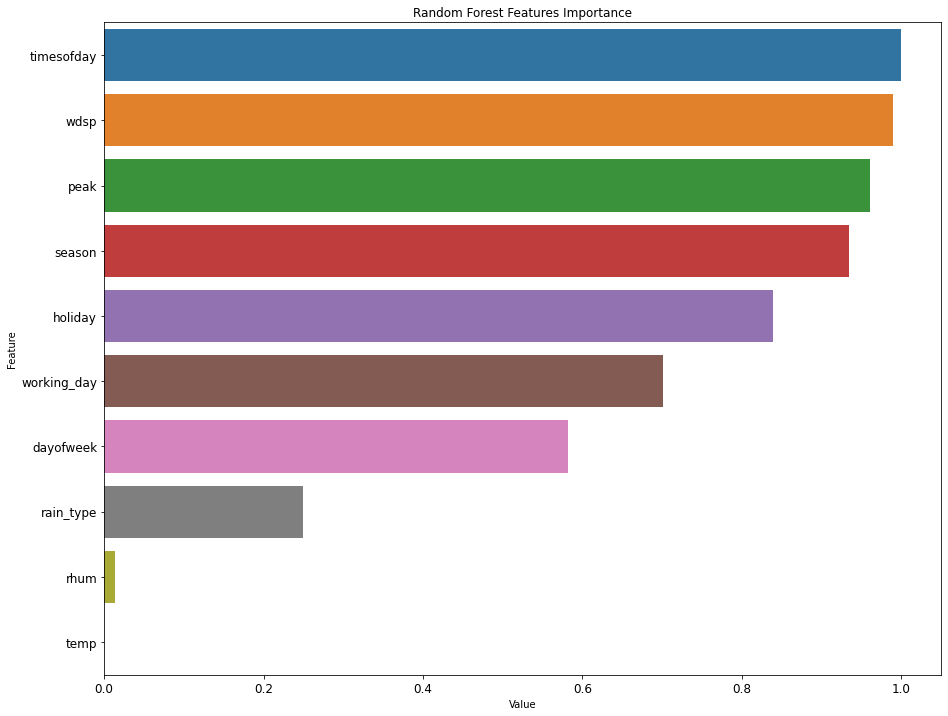

In [13]:
#Plotting features importance
feature_imp = pd.DataFrame(sorted(zip(pipe_rf['model'].feature_importances_,X_train.columns)), 
                           columns=['Value','Feature'])
scaler_ft = MinMaxScaler()
feature_imp['Value'] = scaler_ft.fit_transform(feature_imp['Value'].values.reshape(-1,1));

fig = plt.figure(figsize=(15, 12))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('Random Forest Features Importance')
locs, labels = plt.xticks()
plt.tick_params(axis='both', which='major', labelsize=12)

plt.show()

In [15]:
from sklearn.inspection import permutation_importance
import shap

In [16]:
perm_importance = permutation_importance(pipe_rf, X_test, y_test)

In [26]:
perm_importance

{'importances_mean': array([0.08221604, 0.16911993, 0.00725372, 0.0023072 , 0.02915006,
        0.00881072, 0.02786071, 0.04106132, 0.28433673, 0.00574815]),
 'importances_std': array([0.00400861, 0.01925706, 0.00318497, 0.00053067, 0.0035655 ,
        0.0013148 , 0.00367139, 0.00492719, 0.00462203, 0.00179732]),
 'importances': array([[0.08166053, 0.08303394, 0.08914898, 0.08026391, 0.07697286],
        [0.18570406, 0.17648185, 0.18659132, 0.13495779, 0.16186463],
        [0.00847793, 0.00534775, 0.01099289, 0.00205531, 0.00939473],
        [0.00240963, 0.00213196, 0.00150338, 0.00233533, 0.0031557 ],
        [0.03195476, 0.03457041, 0.02688944, 0.02486019, 0.02747552],
        [0.00959177, 0.00997252, 0.00730609, 0.00712128, 0.01006196],
        [0.03093017, 0.02695938, 0.02665653, 0.03263452, 0.02212293],
        [0.04640973, 0.03336568, 0.04611459, 0.04118491, 0.03823169],
        [0.28658365, 0.29007879, 0.2829703 , 0.27628206, 0.28576885],
        [0.00508658, 0.00811529, 0.00587

In [25]:
sorted_idx = perm_importance.importances_mean.argsort()
sorted_idx
# plt.barh(feature_imp[sorted_idx], perm_importance.importances_mean[sorted_idx])
# plt.xlabel("Permutation Importance")

array([3, 9, 2, 5, 6, 4, 7, 0, 1, 8])

In [ ]:
# random forest model
params_rf = {'n_estimators': 1000, 
             'max_depth': 20, 
             'random_state': 0, 
             'min_samples_split' : 5,
             'n_jobs': -1}

# Fit a pipeline with transformers and an estimator to the training data
pipe_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(**params_rf, criterion='mae'))
])
pipe_rf.fit(X_train, y_train)

#Plotting features importance
feature_imp = pd.DataFrame(sorted(zip(pipe_gbm['model'].feature_importances_,X_train.columns)), 
                           columns=['Value','Feature'])
scaler_ft = MinMaxScaler()
feature_imp['Value'] = scaler_ft.fit_transform(feature_imp['Value'].values.reshape(-1,1));

fig = plt.figure(figsize=(15, 12))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('Random Forest Features Importance')
locs, labels = plt.xticks()
plt.tick_params(axis='both', which='major', labelsize=12)

plt.show()

In [ ]:
# random forest model
params_rf = {'n_estimators': 1000, 
             'max_depth': 20, 
             'random_state': 0, 
             'min_samples_split' : 5, 
             'n_jobs': -1}

# Fit a pipeline with transformers and an estimator to the training data
pipe_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(**params_rf))
])
pipe_rf.fit(X_train, y_train)
# y_train_pred = pipe_rf.predict(X_train)
# y_test_pred = pipe_rf.predict(X_test)

# print_evalmetrics(y_test, y_test_pred)

## Support Vector Regression

In [ ]:
from sklearn.svm import SVR

# Fit a pipeline with transformers and an estimator to the training data
pipe_svr = Pipeline([
    ('preprocessor', preprocessor),
    ('model', SVR(kernel='poly',gamma='scale',C=100))
])
pipe_svr.fit(X_train, y_train)
y_train_pred = pipe_svr.predict(X_train)
y_test_pred = pipe_svr.predict(X_test)

print_evalmetrics(y_test, y_test_pred)

In [ ]:
from numpy import mean
from numpy import std
from numpy import absolute
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

# define the model cross-validation configuration
cv = KFold(n_splits=10, shuffle=True, random_state=1)
# evaluate the pipeline using cross validation and calculate MAE
scores = cross_val_score(pipe_svr, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# convert MAE scores to positive values
scores = absolute(scores)
# summarize the model performance
print('MAE: %.3f (%.3f)' % (mean(scores), std(scores)))
y_test_pred = pipe_svr.predict(X_test)
print_evalmetrics(y_test, y_test_pred)

In [ ]:
predicted_values = pd.DataFrame()
predicted_values['real'] = y_test
predicted_values['predicted'] = y_test_pred

predicted_values

## GradientBoost

In [ ]:
# GBM model
params_gbm = {'n_estimators': 150, 
              'max_depth': 5, 
              'random_state': 0, 
              'min_samples_leaf' : 10, 
              'learning_rate': 0.01, 
              'subsample': 0.7, 
              'loss': 'ls'}

# Fit a pipeline with transformers and an estimator to the training data
pipe_gbm = Pipeline([
    ('preprocessor', preprocessor),
    ('model', GradientBoostingRegressor(**params_gbm))
])
pipe_gbm.fit(X_train, y_train)
y_train_pred = pipe_gbm.predict(X_train)
y_test_pred = pipe_gbm.predict(X_test)

print_evalmetrics(y_test, y_test_pred)

## LightGBM

In [ ]:
# LightGBM model
params_lightgbm = {'n_estimators': 1000, 
                   'max_depth': 15, 
                   'random_state': 0, 
                   'learning_rate': 0.01, 
                   'subsample': 0.7,
                   'num_leaves': 30,
                   'metric': 'rmse',
                   'n_jobs': 2
                   }

# Fit a pipeline with transformers and an estimator to the training data
pipe_gbm = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LGBMRegressor(**params_lightgbm))
])
pipe_gbm.fit(X_train, y_train)
y_train_pred = pipe_gbm.predict(X_train)
y_test_pred = pipe_gbm.predict(X_test)

print_evalmetrics(y_test, y_test_pred)

In [ ]:
%%time

cv = KFold(n_splits=3, shuffle=True, random_state=2022)

for n_fold, (train_index, test_index) in enumerate(cv.split(X_train, y_train)):
    print('#'*40, f'Fold {n_fold+1} out of {cv.n_splits}', '#'*40)
    
    # X_train, y_train = X[train_index], y[train_index] # Train data
    # X_val, y_val = X[test_index], y[test_index] # Valid data
    
    # pipe_gbm.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)],
    #           verbose=250, early_stopping_rounds=50)
    
    # preds_lgb[test_index] += pipe_gbm.predict(X_val, raw_score=False)

## Catboost

In [ ]:
# Catboost model

# Fit a pipeline with transformers and an estimator to the training data
pipe_catboost = Pipeline([
    ('preprocessor', preprocessor),
    ('model', CatBoostRegressor(verbose=1, n_estimators=100))
])
pipe_catboost.fit(X_train, y_train)
y_train_pred = pipe_catboost.predict(X_train)
y_test_pred = pipe_catboost.predict(X_test)

print('\n')
print_evalmetrics(y_test, y_test_pred)

<img title="GitHub Mark" src="./img/GitHub-Mark-64px.png" style="height: 32px; padding-right: 15px" alt="GitHub Mark" align="left"> [GitHub repository](https://github.com/pessini/moby-bikes) <br>Author: Leandro Pessini